In [1]:
# pip install opencv-python

In [2]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)

Versions of key libraries
---
tensorflow:  2.6.0
numpy:       1.22.3
matplotlib:  3.5.2
sklearn:     1.1.1


In [3]:
modelname   = 'base'

IMGSIZE = 128
EPOCHS = 200
BATCH_SIXE = 64
OPT_IDX = 1

modelname = modelname+"_"+str(IMGSIZE)+"_"+str(EPOCHS)+"_"+str(BATCH_SIXE)+"_"+str(OPT_IDX)
optmzs = ['adam', optimizers.RMSprop(learning_rate=0.0001)]
optmz = optmzs[OPT_IDX]

In [4]:
def createModel():
    model = Sequential()
    model.add(Conv2D(64, (5,5), padding='same', input_shape=(IMGSIZE,IMGSIZE,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.15))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optmz, metrics=['accuracy'])
    return model

model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0

In [5]:
                                                                                # Step 1
modelname       = modelname+"_"+str(datetime.datetime.now())[:-7].replace(' ','_').replace(":",'-')
folderpath      = 'models/'
filepath        = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Path to model:", filepath)
print("Path to log:  ", folderpath+modelname+'.csv')

Path to model: models/base_128_200_64_1_2022-09-18_17-14-53.hdf5
Path to log:   models/base_128_200_64_1_2022-09-18_17-14-53.csv


In [6]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')
print("Path to plot:", plotpath)

Path to plot: models/base_128_200_64_1_2022-09-18_17-14-53_plot.png


In [7]:
data_dir = pathlib.Path("dataset")
fish_images_dict = {
    'arowana': list(data_dir.glob('arowana/*.jpg')),
    'betta': list(data_dir.glob('betta/*.jpg')),
    'goldfish': list(data_dir.glob('goldfish/*.jpg')),
    'luohan': list(data_dir.glob('luohan/*.jpg'))
}
labelname = ['arowana','betta','goldfish','luohan']

In [8]:
X, y = [], []

for fish_name, images in fish_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(IMGSIZE,IMGSIZE))
        X.append(resized_img)
        y.append(labelname.index(fish_name))

In [9]:
X = np.array(X)
oy = np.array(y)
y = to_categorical(oy)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train  = X_train / 255
X_test   = X_test / 255

In [10]:
history = model.fit(X_train,                            # Training data
          y_train,                            # Training label
          validation_data=(X_test, y_test),   # Validation data and label
          epochs=EPOCHS,                       # The amount of epochs to be trained
          batch_size=BATCH_SIXE,                   
          shuffle=True,                     # To shuffle the training data
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints

Epoch 1/200
36/36 [==============================] - 6s 40ms/step - loss: 1.2436 - accuracy: 0.4201 - val_loss: 1.1638 - val_accuracy: 0.4655
Epoch 2/200
36/36 [==============================] - 1s 31ms/step - loss: 1.1545 - accuracy: 0.4609 - val_loss: 1.1355 - val_accuracy: 0.5046
Epoch 3/200
36/36 [==============================] - 1s 30ms/step - loss: 1.1105 - accuracy: 0.4696 - val_loss: 1.0889 - val_accuracy: 0.4772
Epoch 4/200
36/36 [==============================] - 1s 31ms/step - loss: 1.0629 - accuracy: 0.4918 - val_loss: 1.0504 - val_accuracy: 0.4915
Epoch 5/200
36/36 [==============================] - 1s 31ms/step - loss: 1.0167 - accuracy: 0.5148 - val_loss: 1.0275 - val_accuracy: 0.5163
Epoch 6/200
36/36 [==============================] - 1s 31ms/step - loss: 0.9777 - accuracy: 0.5460 - val_loss: 0.9830 - val_accuracy: 0.5410
Epoch 7/200
36/36 [==============================] - 1s 31ms/step - loss: 0.9470 - accuracy: 0.5603 - val_loss: 0.9428 - val_accuracy: 0.5761
Epoch 

36/36 [==============================] - 1s 32ms/step - loss: 0.4552 - accuracy: 0.8142 - val_loss: 0.5697 - val_accuracy: 0.7763
Epoch 59/200
36/36 [==============================] - 1s 32ms/step - loss: 0.4555 - accuracy: 0.8216 - val_loss: 0.5125 - val_accuracy: 0.8153
Epoch 60/200
36/36 [==============================] - 1s 32ms/step - loss: 0.4415 - accuracy: 0.8251 - val_loss: 0.5411 - val_accuracy: 0.7893
Epoch 61/200
36/36 [==============================] - 1s 31ms/step - loss: 0.4317 - accuracy: 0.8359 - val_loss: 0.4989 - val_accuracy: 0.8218
Epoch 62/200
36/36 [==============================] - 1s 31ms/step - loss: 0.4411 - accuracy: 0.8247 - val_loss: 0.5109 - val_accuracy: 0.8049
Epoch 63/200
36/36 [==============================] - 1s 32ms/step - loss: 0.4366 - accuracy: 0.8212 - val_loss: 0.4860 - val_accuracy: 0.8205
Epoch 64/200
36/36 [==============================] - 1s 31ms/step - loss: 0.4336 - accuracy: 0.8312 - val_loss: 0.4938 - val_accuracy: 0.8205
Epoch 65/200

36/36 [==============================] - 1s 31ms/step - loss: 0.2991 - accuracy: 0.8902 - val_loss: 0.4175 - val_accuracy: 0.8622
Epoch 116/200
36/36 [==============================] - 1s 32ms/step - loss: 0.2769 - accuracy: 0.8984 - val_loss: 0.3930 - val_accuracy: 0.8791
Epoch 117/200
36/36 [==============================] - 1s 32ms/step - loss: 0.2800 - accuracy: 0.8963 - val_loss: 0.4091 - val_accuracy: 0.8622
Epoch 118/200
36/36 [==============================] - 1s 32ms/step - loss: 0.2896 - accuracy: 0.8993 - val_loss: 0.3751 - val_accuracy: 0.8596
Epoch 119/200
36/36 [==============================] - 1s 32ms/step - loss: 0.2884 - accuracy: 0.8924 - val_loss: 0.3850 - val_accuracy: 0.8674
Epoch 120/200
36/36 [==============================] - 1s 32ms/step - loss: 0.2728 - accuracy: 0.9006 - val_loss: 0.4139 - val_accuracy: 0.8544
Epoch 121/200
36/36 [==============================] - 1s 32ms/step - loss: 0.2838 - accuracy: 0.8941 - val_loss: 0.3870 - val_accuracy: 0.8518
Epoch 

Epoch 172/200
36/36 [==============================] - 1s 31ms/step - loss: 0.1934 - accuracy: 0.9271 - val_loss: 0.3478 - val_accuracy: 0.8843
Epoch 173/200
36/36 [==============================] - 1s 32ms/step - loss: 0.1911 - accuracy: 0.9301 - val_loss: 0.3297 - val_accuracy: 0.8921
Epoch 174/200
36/36 [==============================] - 1s 32ms/step - loss: 0.1897 - accuracy: 0.9327 - val_loss: 0.3387 - val_accuracy: 0.8830
Epoch 175/200
36/36 [==============================] - 1s 32ms/step - loss: 0.1823 - accuracy: 0.9293 - val_loss: 0.3705 - val_accuracy: 0.8804
Epoch 176/200
36/36 [==============================] - 1s 32ms/step - loss: 0.2065 - accuracy: 0.9245 - val_loss: 0.3315 - val_accuracy: 0.8843
Epoch 177/200
36/36 [==============================] - 1s 32ms/step - loss: 0.1994 - accuracy: 0.9306 - val_loss: 0.3455 - val_accuracy: 0.8843
Epoch 178/200
36/36 [==============================] - 1s 32ms/step - loss: 0.1949 - accuracy: 0.9327 - val_loss: 0.3623 - val_accuracy:

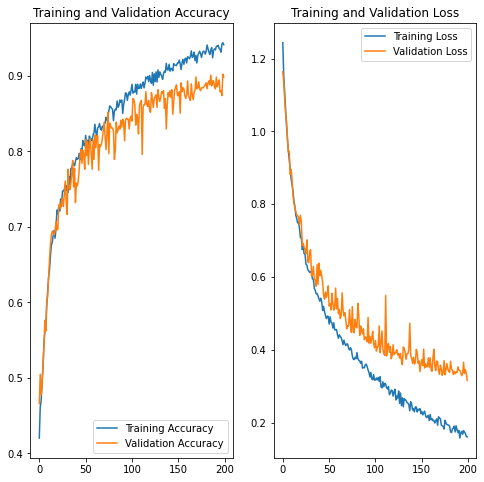

In [11]:
# Plot the accuracy and error on training and test sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(folderpath+modelname+'_accuracy_plot.png')
plt.show()

In [12]:
                                                                                # Step 1
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', 
                optimizer=optmz, 
                metrics=['accuracy'])

predicts    = modelGo.predict(X_test)                                            # Step 2
print("Prediction completes.")

Prediction completes.


In [13]:
                                                                                # Step 1
                                                                                # Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_test,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4))

report = metrics.classification_report(testout,
                                    predout,
                                    target_names=labelname,
                                    digits=4,
                                      output_dict=True)

df = pd.DataFrame(report).transpose()
df.to_csv(folderpath+modelname+'_report.csv')

Best accuracy (on testing dataset): 90.25%
              precision    recall  f1-score   support

     arowana     0.8635    0.9213    0.8914       254
       betta     0.9167    0.9442    0.9302       233
    goldfish     0.8947    0.7391    0.8095        23
      luohan     0.9331    0.8610    0.8956       259

    accuracy                         0.9025       769
   macro avg     0.9020    0.8664    0.8817       769
weighted avg     0.9040    0.9025    0.9021       769

